In [19]:
# This is a Python implementation of Neural Networks, retrieved from the Javier Ideami from Towards Data Science, from 
# https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2
# This was modified to fit the needed layers for the implementation of neural networks, determining the relationship
# of the weather parameters to the number of additional COVID-19 cases in the Philippines

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# For displaying values, not to limit the possible lines to be printed
np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# For plotting the confusion matrix
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

In [21]:
# Sigmoid function (for output layer)
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

# Rectified Linear Unit Function (for hidden layers)
def Relu(Z):
    return np.maximum(0,Z)

# Derivative of ReLU for two hidden layers
def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

# Derivative of ReLU
def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

# Derivative of Sigmoid
def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    # Initial values of the neural network, could be modified by the user
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1])) 
        self.L=2
        self.dims = [3, 15, 15, 1] 
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        self.threshold=0.5
    
    # Randomization of weights and biases
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))
        self.param['W3'] = np.random.randn(self.dims[3], self.dims[2]) / np.sqrt(self.dims[2]) 
        self.param['b3'] = np.zeros((self.dims[3], 1))   
        return 

    # Feedforward loop
    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1
        
        Z2 = self.param['W2'].dot(A1) + self.param['b2']
        A2 = Relu(Z2)
        self.ch['Z2'], self.ch['A2'] = Z2, A2
        
        Z3 = self.param['W3'].dot(A2) + self.param['b3']
        A3 = Sigmoid(Z3)
        self.ch['Z3'], self.ch['A3'] = Z3, A3

        self.Yh=A3
        loss=self.nloss(A3)
        return self.Yh, loss

    # Calcuating error
    def nloss(self,Yh):
        clipped_Yh = np.clip(Yh, 1e-7, 1 - 1e-7)
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(clipped_Yh).T) - np.dot(1-self.Y, np.log(1-clipped_Yh).T))    
        return loss
    
    # Backpropagation
    def backward(self):
        clipped_Yh = np.clip(self.Yh, 1e-7, 1 - 1e-7)
        dLoss_Yh = - (np.divide(self.Y, clipped_Yh) - np.divide(1 - self.Y, 1 - clipped_Yh))  
        
        dLoss_Z3 = dLoss_Yh * dSigmoid(self.ch['Z3'])
        dLoss_A2 = np.dot(self.param['W3'].T, dLoss_Z3)
        dLoss_W3 = 1./self.ch['A2'].shape[1] * np.dot(dLoss_Z3, self.ch['A2'].T)
        dLoss_b3 = 1./self.ch['A2'].shape[1] * np.dot(dLoss_Z3, np.ones([dLoss_Z3.shape[1], 1]))
        
        dLoss_Z2 = dLoss_A2 * dSigmoid(self.ch['Z2'])
        dLoss_A1 = np.dot(self.param['W2'].T, dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1], 1]))

        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
        self.param["W3"] = self.param["W3"] - self.lr * dLoss_W3
        self.param["b3"] = self.param["b3"] - self.lr * dLoss_b3
        
        return

    # Accuracy of the prediction
    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0
    
        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
        
        return comp
    
    # For the gradient descent, calls backpropagation to change the weights' values
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
        
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)

        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iter')
        plt.title("Lr =" + str(self.lr))
        plt.show()
    
        return

In [22]:
# Retrieve the data set
df = pd.read_csv('weather-params-covid-cases.csv',header=None)
header = df.iloc[0]
df = df[1:]
df.columns = header
df = df.astype(float)

# Scaling of dataset so the values would only be between 0 and 1
# Neural network works much better for this range of values

scaled_df=df
names = df.columns[0:3]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:3]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)

print(scaled_df.head(5))

0   MAXTEMP  MAXWNDSPD      PRCP
0  0.111111   0.063592  0.000000
1  0.461538   0.130532  0.000000
2  0.726496   0.063592  0.000000
3  0.367521   0.261064  0.013636
4  0.769231   0.261064  0.000000


In [23]:
# Designation of values for training or validation set
x = scaled_df.iloc[0:50, 0:3].values.transpose()
y = df.iloc[0:50, 3:].values.transpose()
xval = scaled_df.iloc[50:63, 0:3].values.transpose()
yval = df.iloc[50:63, 3:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

nn = dlnet(x,y)
nn.lr=0.05
nn.dims = [3, 25, 20, 1]

(62, 4) (3, 50) (1, 50) (3, 12) (1, 12)


Cost after iteration 0: 0.688088
Cost after iteration 500: 0.569418
Cost after iteration 1000: 0.564899
Cost after iteration 1500: 0.560317
Cost after iteration 2000: 0.556327
Cost after iteration 2500: 0.552861
Cost after iteration 3000: 0.549597
Cost after iteration 3500: 0.546834
Cost after iteration 4000: 0.544145
Cost after iteration 4500: 0.541401
Cost after iteration 5000: 0.538483
Cost after iteration 5500: 0.535273
Cost after iteration 6000: 0.531563
Cost after iteration 6500: 0.527587
Cost after iteration 7000: 0.523486
Cost after iteration 7500: 0.519646
Cost after iteration 8000: 0.515474
Cost after iteration 8500: 0.510736
Cost after iteration 9000: 0.506055
Cost after iteration 9500: 0.501333
Cost after iteration 10000: 0.496655
Cost after iteration 10500: 0.491817
Cost after iteration 11000: 0.487327
Cost after iteration 11500: 0.482963
Cost after iteration 12000: 0.478365
Cost after iteration 12500: 0.473656
Cost after iteration 13000: 0.469251
Cost after iteration 1350

Cost after iteration 111000: 0.049328
Cost after iteration 111500: 0.049357
Cost after iteration 112000: 0.049415
Cost after iteration 112500: 0.049244
Cost after iteration 113000: 0.049035
Cost after iteration 113500: 0.048816
Cost after iteration 114000: 0.048603
Cost after iteration 114500: 0.048375
Cost after iteration 115000: 0.048139
Cost after iteration 115500: 0.047884
Cost after iteration 116000: 0.047615
Cost after iteration 116500: 0.047252
Cost after iteration 117000: 0.046979
Cost after iteration 117500: 0.046834
Cost after iteration 118000: 0.046842
Cost after iteration 118500: 0.046899
Cost after iteration 119000: 0.046638
Cost after iteration 119500: 0.046515
Cost after iteration 120000: 0.046400
Cost after iteration 120500: 0.046136
Cost after iteration 121000: 0.045743
Cost after iteration 121500: 0.045637
Cost after iteration 122000: 0.046766
Cost after iteration 122500: 0.039693
Cost after iteration 123000: 0.039006
Cost after iteration 123500: 0.039125
Cost after i

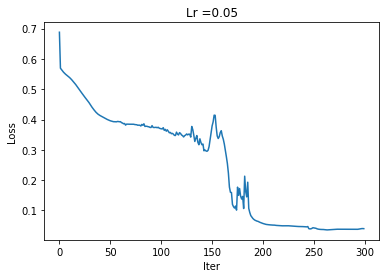

In [24]:
nn.gd(x, y, iter = 150000)

In [25]:
# Accuracy of the training process and the validation process
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)

Acc: 0.9800000000000002
Acc: 0.41666666666666663


Acc: 0.9800000000000002


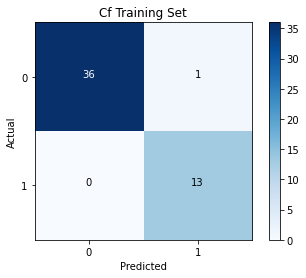

Acc: 0.41666666666666663


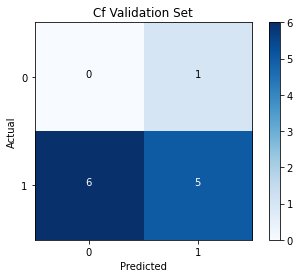

In [26]:
# Succeeding lines of code would be checking the changes if threshold value would be increased
nn.threshold=0.5

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

Acc: 0.9800000000000002


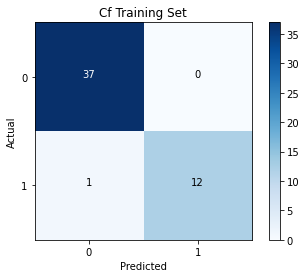

Acc: 0.49999999999999994


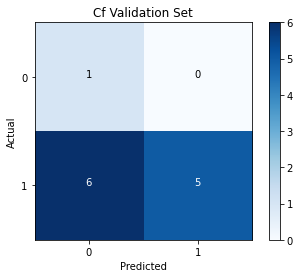

In [27]:
nn.threshold=0.7

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

Acc: 0.9600000000000002


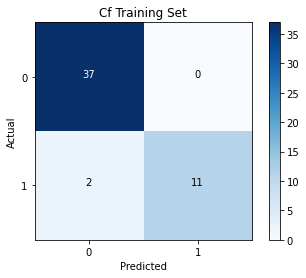

Acc: 0.49999999999999994


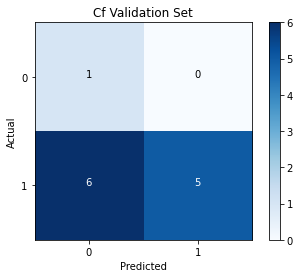

In [28]:
nn.threshold=0.9

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')